In [1]:
!which python

/Users/licongshen/Desktop/Kalman-Filter-Based-Trading/.venv/bin/python


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

In [46]:
def estimate_kalman_hedge_ratio(y: pd.Series, x: pd.Series) -> pd.DataFrame:
    """
    Uses a Kalman Filter to estimate a time-varying intercept and hedge ratio (beta)
    between two price series y and x.
    """
    y_vals = y.to_numpy(dtype=np.float64)
    x_vals = x.to_numpy(dtype=np.float64)
    n = len(y_vals)

    if n != len(x_vals):
        raise ValueError("x and y must be the same length")

    observation_matrices = np.array([[1.0, x_t] for x_t in x_vals], dtype=np.float64).reshape(n, 1, 2)

    kf = KalmanFilter(
        transition_matrices=np.eye(2),
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.eye(2),
        observation_covariance=1.0,
        transition_covariance=0.01 * np.eye(2),
    )
    # Do NOT pass it to .filter() — instead, set it before
    kf.observation_matrices = observation_matrices
    state_means, _ = kf.filter(y_vals)  # <- no keyword args here

    intercept = state_means[:, 0]
    beta = state_means[:, 1]
    spread = y_vals - (intercept + beta * x_vals)

    return pd.DataFrame({
        "intercept": intercept,
        "beta": beta,
        "spread": spread
    }, index=y.index)

In [47]:
# Load from processed CSVs
df_y = pd.read_csv("/Users/benwong/Kalman-Filter-Based-Trading/data/processed/btc_usdt_processed.csv", index_col=0, parse_dates=True)
df_x = pd.read_csv("/Users/benwong/Kalman-Filter-Based-Trading/data/processed/btc_3m_processed.csv", index_col=0, parse_dates=True)

# Align by timestamp
df = pd.concat([
    df_y[["close"]].rename(columns={"close": "y"}),
    df_x[["close"]].rename(columns={"close": "x"})
], axis=1, join="inner").dropna()

y = df["y"]
x = df["x"]

In [48]:
kalman_df = estimate_kalman_hedge_ratio(y, x)
kalman_df.tail()

,intercept,beta,spread
timestamp,,,
2025-03-28 23:09:00,0.000012,0.986855,4.080066e-07
2025-03-28 23:10:00,0.000012,0.988056,1.406792e-06
2025-03-28 23:11:00,0.000012,0.987629,-5.001930e-07
2025-03-28 23:12:00,0.000012,0.987603,-3.016612e-08
2025-03-28 23:13:00,0.000012,0.987928,3.802124e-07


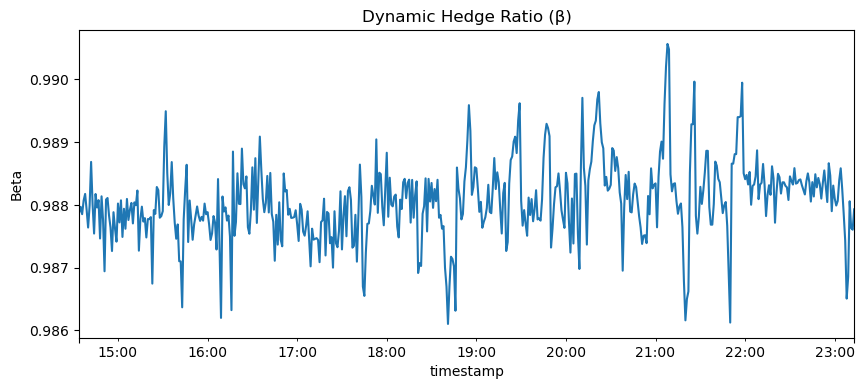

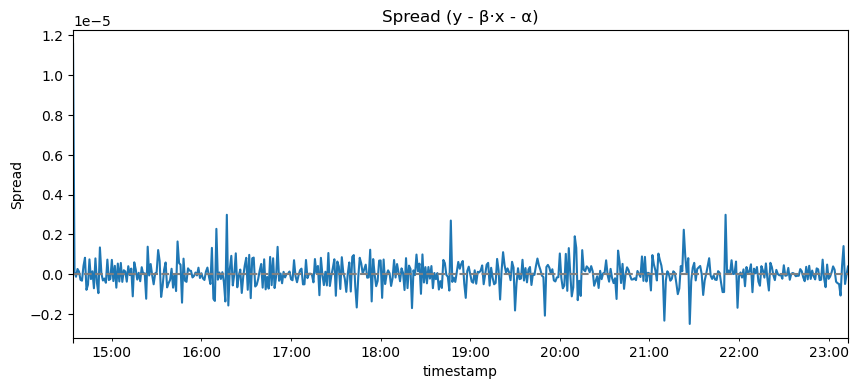

In [49]:
kalman_df["beta"].plot(title="Dynamic Hedge Ratio (β)", figsize=(10, 4))
plt.ylabel("Beta")
plt.show()

kalman_df["spread"].plot(title="Spread (y - β·x - α)", figsize=(10, 4))
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Spread")
plt.show()

In [50]:
def generate_zscore_signals(spread: pd.Series, entry_z=2.0, exit_z=0.5):
    z = (spread - spread.rolling(60).mean()) / spread.rolling(60).std()
    signals = pd.Series(index=spread.index, dtype=object)

    signals[z > entry_z] = "short_spread"
    signals[z < -entry_z] = "long_spread"
    signals[abs(z) < exit_z] = "exit"

    return z, signals

kalman_df["zscore"], kalman_df["signal"] = generate_zscore_signals(kalman_df["spread"])
kalman_df[["spread", "zscore", "signal"]].tail()

,spread,zscore,signal
timestamp,,,
2025-03-28 23:09:00,4.080066e-07,1.209392,NaN
2025-03-28 23:10:00,1.406792e-06,3.524507,short_spread
2025-03-28 23:11:00,-5.001930e-07,-1.198641,NaN
2025-03-28 23:12:00,-3.016612e-08,-0.024307,exit
2025-03-28 23:13:00,3.802124e-07,0.962053,NaN


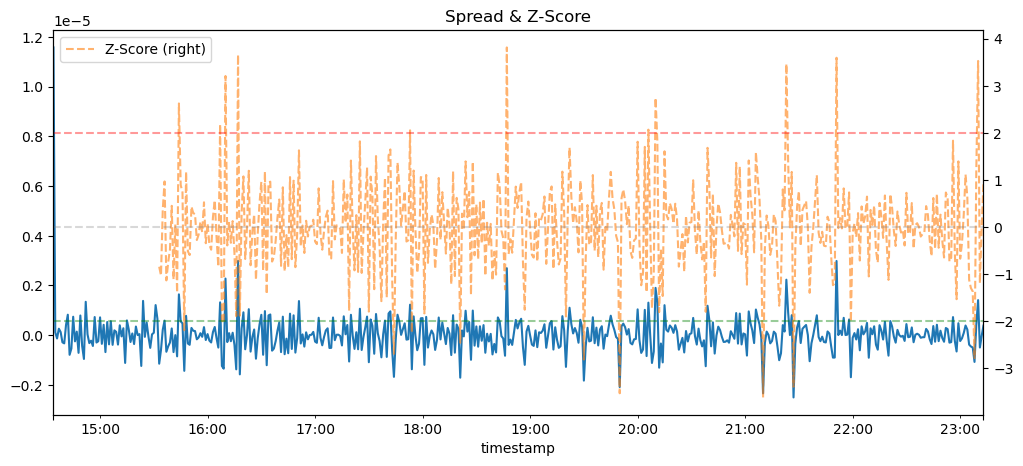

In [51]:
fig, ax = plt.subplots(figsize=(12, 5))
kalman_df["spread"].plot(ax=ax, label="Spread")
kalman_df["zscore"].plot(ax=ax, secondary_y=True, label="Z-Score", linestyle='--', alpha=0.6)

plt.axhline(2, color='red', linestyle='--', alpha=0.4)
plt.axhline(-2, color='green', linestyle='--', alpha=0.4)
plt.axhline(0, color='gray', linestyle='--', alpha=0.3)

plt.title("Spread & Z-Score")
plt.legend()
plt.show()